## Multi-Class Classification

In [1]:
# creating dataset

import sklearn
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=2)

In [2]:
X[:10], y[:10]

(array([[ -0.31332345,  -4.25352048],
        [ -2.68531026,  -3.61156024],
        [ -1.07861486,  -3.40556561],
        [  1.11104611,  -1.83023746],
        [  1.41707052,  -1.10459115],
        [ -0.58498235, -11.51494191],
        [  0.79040882,  -0.62240538],
        [ -2.1971023 ,  -3.27748644],
        [ -5.27570816,   1.97451034],
        [ -2.45274005,  -2.02198311]]),
 array([2, 2, 2, 1, 1, 0, 1, 2, 3, 2]))

In [3]:
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
import torch

In [5]:
# converting to tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
y_train[:10]

tensor([3., 3., 2., 1., 2., 2., 1., 2., 2., 3.])

In [14]:
X_train[:10]

tensor([[-6.6964,  0.5497],
        [-5.0904,  2.4512],
        [-2.2908, -4.6499],
        [ 0.8179, -1.5432],
        [-2.5193, -2.7930],
        [-4.1070, -3.8084],
        [ 0.3956, -0.9556],
        [-1.8241, -3.5195],
        [-0.5009, -2.9191],
        [-6.7455,  4.0436]])

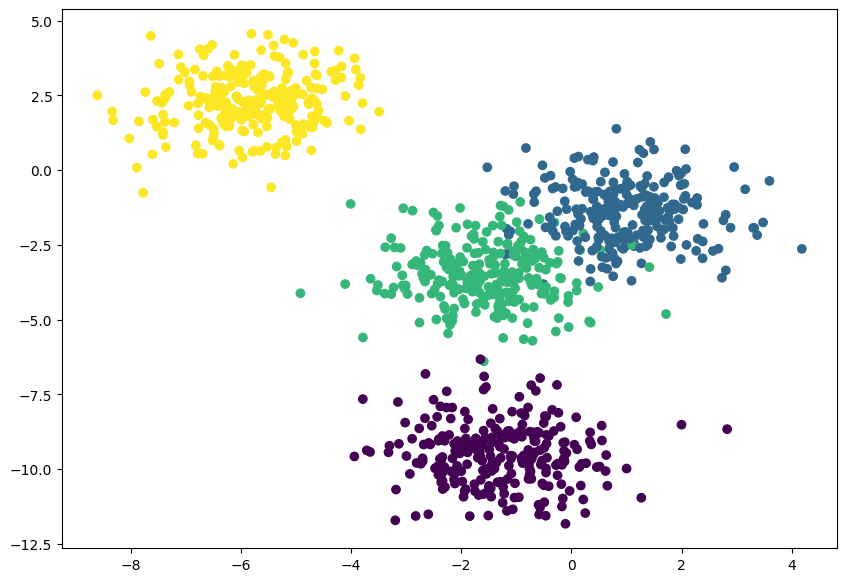

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [9]:
# building multiclass classification model
from torch import nn

In [13]:
class MultiClassClassification(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer(x)

model = MultiClassClassification(2, 4).to(device)
model

MultiClassClassification(
  (linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [11]:
device

'cpu'

In [15]:
torch.unique(y_train)

tensor([0., 1., 2., 3.])

In [16]:
loss_fn = nn.CrossEntropyLoss() # cross entropy function
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [20]:
# before training inference test on test data

model.eval()
with torch.inference_mode():
  y_logits = model(X_test)
  y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

y_pred[:10], y_logits[:10]

(tensor([0, 1, 2, 1, 0, 0, 0, 2, 0, 1]),
 tensor([[0.5368, 0.4894, 0.3924, 0.3524],
         [0.4973, 0.5020, 0.3488, 0.3425],
         [0.2961, 0.2093, 0.5338, 0.4396],
         [0.6578, 0.7917, 0.4903, 0.5068],
         [0.4880, 0.4722, 0.3520, 0.3353],
         [0.4356, 0.4331, 0.3172, 0.3139],
         [0.5266, 0.5097, 0.3741, 0.3524],
         [0.3494, 0.3548, 0.4443, 0.4018],
         [0.5328, 0.4949, 0.3862, 0.3520],
         [0.7384, 0.7785, 0.4694, 0.4554]]))

In [23]:
# train and test loop

for epoch in range(epochs):
  # train
  model.train()
  # ouput number
  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_train.type(torch.LongTensor))
  acc = (y_pred == y_train).sum() / len(y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_test.type(torch.LongTensor))
    test_acc = (test_pred == y_test).sum() / len(y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.38346 | Acc: 0.25 | Test Loss: 1.37357 | Test Acc: 0.23
Epoch: 100 | Loss: 0.27678 | Acc: 0.93 | Test Loss: 0.25858 | Test Acc: 0.94
Epoch: 200 | Loss: 0.18421 | Acc: 0.94 | Test Loss: 0.16275 | Test Acc: 0.98
Epoch: 300 | Loss: 0.10754 | Acc: 0.98 | Test Loss: 0.10609 | Test Acc: 0.99
Epoch: 400 | Loss: 0.08013 | Acc: 0.98 | Test Loss: 0.08734 | Test Acc: 0.98
Epoch: 500 | Loss: 0.06975 | Acc: 0.98 | Test Loss: 0.08090 | Test Acc: 0.98
Epoch: 600 | Loss: 0.06463 | Acc: 0.98 | Test Loss: 0.07842 | Test Acc: 0.98
Epoch: 700 | Loss: 0.06209 | Acc: 0.98 | Test Loss: 0.07718 | Test Acc: 0.98
Epoch: 800 | Loss: 0.06054 | Acc: 0.98 | Test Loss: 0.07648 | Test Acc: 0.98
Epoch: 900 | Loss: 0.05946 | Acc: 0.98 | Test Loss: 0.07591 | Test Acc: 0.98


In [24]:
# make prediction

model.eval()

with torch.inference_mode():
  y_logits = model(X_test)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_pred[:10], y_logits[:10]

(tensor([2, 3, 1, 0, 3, 3, 2, 1, 2, 0]),
 tensor([[  3.8708,   1.4000,  10.1973,  -6.8569],
         [ -9.4104,   2.6812,   5.0030,  16.1922],
         [ -8.9176,  10.1790,   1.0156,  -0.1969],
         [ 24.4217,  -2.6243,  15.3216, -17.8518],
         [ -8.0222,   2.6415,   4.9459,  13.4280],
         [ -8.7463,   2.9181,   3.9786,  13.6243],
         [  4.5240,   2.4958,   9.3104,  -7.4362],
         [ -4.5976,   8.5259,   4.6326,  -3.4359],
         [  4.0584,   1.8184,   9.8416,  -7.1035],
         [ 25.0667,  -5.8501,  16.8527, -17.4011]]))

In [32]:
import requests

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

response = requests.get(url)
with open("helper_functions.py", "wb") as f:
    f.write(response.content)

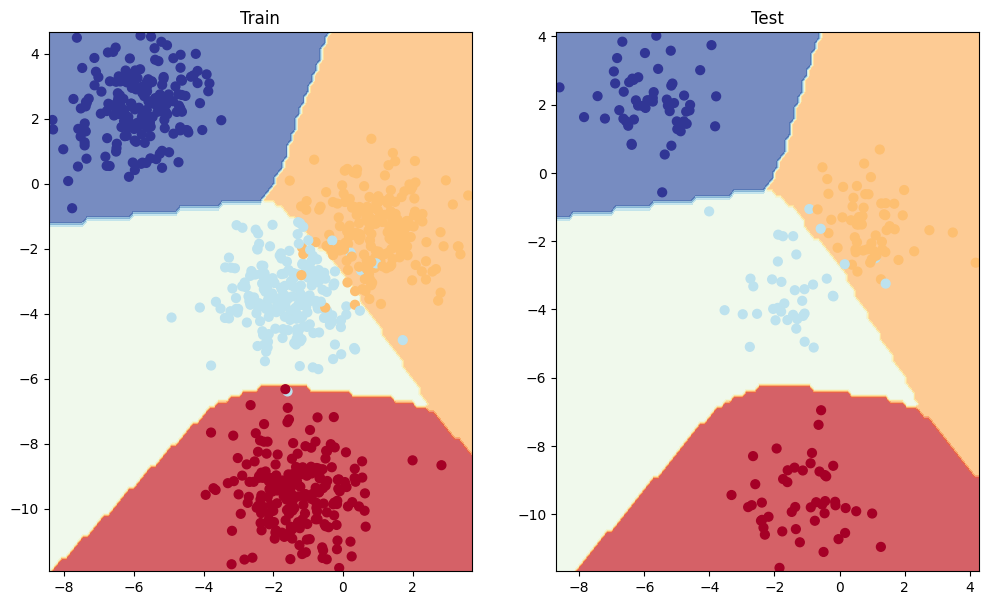

In [34]:
# visualize
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2, 2 )
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)